
# 🪐 Aula: Do espaço real ao espectro de potência

Neste *notebook*, vamos aprender passo a passo como obter o **espectro de potência** de uma imagem, indo do espaço real até a representação em termos de multipolos angulares ($\ell$). Além disto, vamos aprender como calcular barras de erro (matriz de covariância) para o caso em que a matriz é Gaussiana, filtragem de modos utilizando FFT e um exemplo mais realístico utilizando CMB. 

Vamos abordar:

1. Fundamentos da Transformada de Fourier (FFT)
2. Abrindo uma imagem .fits 
3. Cálculo do espectro de potência 2D
4. Conversão do espectro 2D para 1D (média radial)
5. Conversão das frequências em multipolos \( \ell \)
6. Barras de erro- Cálculo da matriz de covariância
7. Filtragem no Espaço de Frequência (FFT 2D)
8. Exemplo data mais realístico : CMB
   * efeito SZ, feixe, ruído, filtragem 


In [6]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from skimage import data
from skimage.color import rgb2gray



## 1️⃣ Fundamentos da Transformada de Fourier em 1-D

 

A **Transformada de Fourier** mostra que qualquer sinal pode ser decomposto em uma soma de funções senoidais individuais de diferentes frequências. Em outras palavras, ela nos permite representar um sinal (ou imagem) não mais em termos de posição, mas de frequência espacial — revelando quais padrões oscilatórios compõem a estrutura do sinal.

<img src="https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png">

No caso contínuo em 1-D, a Transformada de Fourier pode ser escrita como: 

\begin{equation}
\tilde{f}(k) = \int f(x) e^{-2\pi ikfx} dx
\end{equation} 

e a transformada inversa, que reconstrói o sinal no espaço original, é dada por:

\begin{equation}
f(x) = \int \tilde{f}(k) e^{2\pi ikfx} dk
\end{equation} 

onde $f(x)$ é o sinal no espaço real, $\tilde{f}(k)$ é o sinal no espaço de frequências, k representa a frequência espacial (ou simplesmente frequência), e o fator exponencial descreve as oscilações senoidais que compõem o sinal


## 2️⃣ Transformada Discreta de Fourier (DFT) 2D (em imagens)

 
A **Transformada de Fourier discreta (DFT)** permite decompor uma imagem \( I(x, y) \) — onde (x,y) são as coordenadas dos pixels — em suas componentes de frequência espacial. Essa decomposição revela quanta informação (ou potência) está presente em diferentes escalas espaciais da imagem, permitindo analisar padrões periódicos e estruturas em diversas resoluções.
 

\begin{equation}
 \tilde{I}(k_x, k_y) = \sum_{x=0}^{N_{x}-1} \sum_{y=0}^{N_{y}-1} I(x, y) \, e^{-2\pi i (\frac{k_x  x}{N_{x}} + \frac{k_y y}{N_{y}})} \, dx\, dy,
\end{equation}

onde $(k_x, k_y)$ são os índices de frequência espacial, (Nx,Ny) são o número de pixels nas direções x e y.

 


- O cálculo da Transformada de Fourier discreta unidimensional pode ser feito de forma muito eficiente com o algoritmo da Transformada Rápida de Fourier (FFT) com complexidade de tempo O(n log n).
- Este algoritmo pode ser estendido para sinais 2D e está presente na biblioteca numpy através de `numpy.fft.fft2`.

Aviso: o algoritmo fft não retorna a frequência zero no centro do espectro. Precisamos aplicar um deslocamento ao espectro.


# Vamos primeiramente entender FFT em uma imagem arbitrária: 



In [7]:
caller = getattr(data, 'grass')
image = caller()

 

data_ft = np.abs(np.fft.fft2(image))
data_ft_shifted = np.fft.fftshift(data_ft) 

Text(0.5, 1.0, 'Fourier transform shifted $|F(kx,ky)|$')

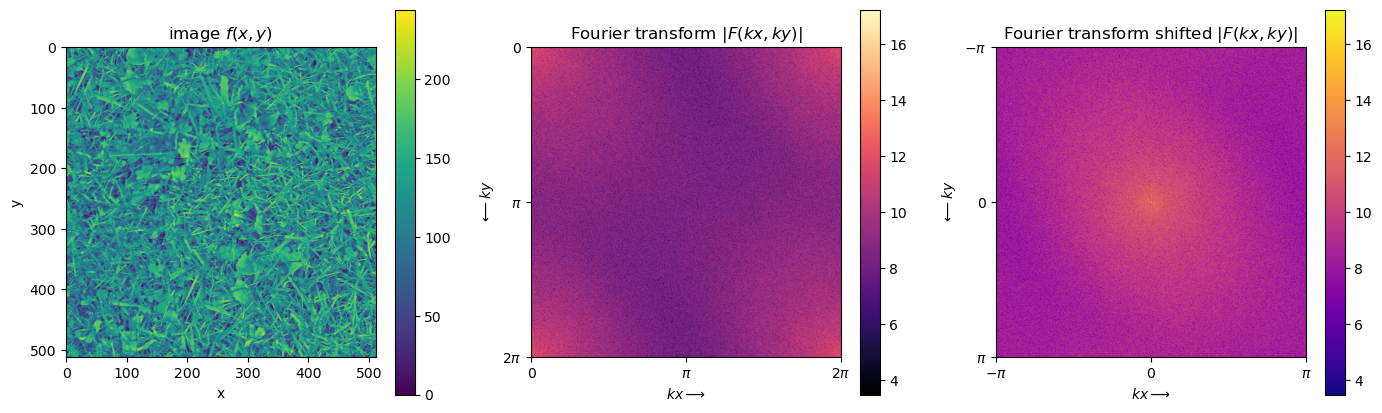

In [8]:
fig = plt.figure(figsize=(17,5))

axes = fig.add_subplot(131)
plt.imshow(image)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title(r"image $f(x,y)$")

axes = fig.add_subplot(132)
plt.imshow(np.log(np.abs(data_ft)), cmap='magma')
plt.colorbar()
axes.xaxis.set_ticks([0,256,512])
axes.xaxis.set_ticklabels(['0', r'$\pi$', r'$2\pi$'])
plt.xlabel(r'$kx \longrightarrow$')
axes.yaxis.set_ticks([0,256,512])
axes.yaxis.set_ticklabels(['0', r'$\pi$', r'$2\pi$'])
plt.ylabel(r'$\longleftarrow ky$')
plt.title(r"Fourier transform $|F(kx,ky)|$")

axes = fig.add_subplot(133)
plt.imshow(np.log(np.abs(data_ft_shifted)), cmap='plasma')
plt.colorbar()
axes.xaxis.set_ticks([0,256,512])
axes.xaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
plt.xlabel(r'$kx \longrightarrow$')
axes.yaxis.set_ticks([0, 256, 512])
axes.yaxis.set_ticklabels([r'$-\pi$', '0', r'$\pi$'])
plt.ylabel(r'$\longleftarrow ky$')
plt.title(r"Fourier transform shifted $|F(kx,ky)|$")

## 3️⃣ Abrindo um mapa de tracer= MB, Lenteamento de galáxias ou densidade de galáxias em .fits: 
 

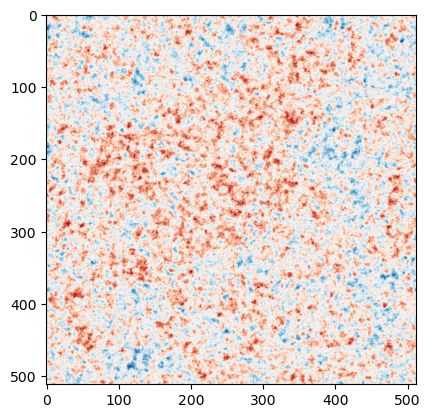

In [9]:
from astropy.io import fits

def read_fits_map(path, hdu=0):
    """Read a FITS image and return data and header."""
    with fits.open(path) as hdul:
        data = hdul[hdu].data.astype(np.float64)
        header = hdul[hdu].header
    return data, header

 
path='data/'
 
mapa, h = read_fits_map(path+'mapa_cmb_noiseless.fits')

plt.imshow(mapa, cmap='RdBu_r')



In [ ]:
#------------------------------------------------------------------
# Defina parametros do mapa: 
npix = len(mapa) #numero de pixels por lado
map_size_deg = 60.0 # Tamanho da lateral do mapa em graus 
map_size_rad = np.deg2rad(map_size_deg)# Tamanho da lateral do mapa em radiano
pix_size = map_size_rad / npix # Pixel size (radians)

print(pix_size, npix, map_size_rad)


## 🧩 Exercícios  

### 🧠 Exercício 1 — FFT do mapa da sonda cosmológica
Visualize o mapa da sonda cosmológica escolhida, sua FFT e a FFT após o deslocamento.
O que você espera ver?


 ## Espectro de potência de um mapa  
O  [espectro de potência de densidade](https://en.wikipedia.org/wiki/Spectral_density#Energy_spectral_density) de uma imagem 2D é $P(kx,ky) = |F(kx,ky)|^2$

### 🧠 Exercício 2 — Espectro de potência 2-D
Calcule e visualize o espetro de potência 2D do mapa da sonda cosmológica escolhida. 

# Etapa 3. Construir a grade ℓ



# Na aproximação de céu-plano (flat-sky), os modos de Fourier $\ell$ correspondem a : 
  
 \begin{equation}
\ell =  2\pi \sqrt{(kx^2 + ky^2  )}
 \end{equation}



In [ ]:
  
# Frequency grid (in radians^-1)
kx = np.fft.fftshift(np.fft.fftfreq(npix, d=pix_size))
ky = np.fft.fftshift(np.fft.fftfreq(npix, d=pix_size))
KX, KY = np.meshgrid(kx, ky)
ell = 2 * np.pi * np.sqrt(KX**2 + KY**2)
 

# Etapa 4. Cálculo do Espectro de potência

Nós queremos obter o $C_{\ell}$ médio radial, ou seja, a média de $|F|^2$ em anéis de $\ell$ constante:  
 


In [ ]:
# Flatten arrays
ell_flat = ell.flatten()
power_flat = power2d.flatten()

# Define ℓ bins
ell_min = 2       # you can tune based on map size
ell_max = 3500
nbins = 30

ell_bins = np.linspace( (ell_min),  (ell_max), nbins+1)

ell_centers = 0.5 * (ell_bins[1:] + ell_bins[:-1])
print(ell_centers)
Cl = np.zeros(nbins)
for i in range(nbins):
    mask = (ell_flat >= ell_bins[i]) & (ell_flat < ell_bins[i+1])
    if np.any(mask):
        Cl[i] = np.mean(power_flat[mask])



plt.plot(ell_centers, Cl ,'o')

# 5) Normalizar o $C_{\ell}$
   
Para comparar o espectro de potência de um mapa com um teórico, é necessário converter todos os valores para unidades universais, ou seja, unidades que não dependem das especificidades do mapa (largura, resolução, tamanho do pixel, etc.).

Na comunidade cosmológica, é comum multiplicar o espectro de potência pelas unidades de *volume* do sinal de interesse. Aqui, o *volume* é uma área, já que trabalhamos com imagens.  Para o caso de céu-plano, precisamos multiplicar o espectro de potência por  (area_do_pixel)   e dividir pela area total 


In [ ]:
Cl = (pix_size**2 / npix**2) * Cl #<---Isso garante que  o mapa tenha dimensões corretas


# 🧩 Defina uma função para o cálculo do Cls a partir de um mapa (será útil depois): 
 

Objetivo: definir uma funcão em que a entrada seja um mapa (2D- flat-sky), tamanho do pixel, tamanho do mapa e multipolos a serem calculados os Cls (ell_bins). Output: Cl (binnado em ell_bins).  


# Mas como garantir que as medidas estão precisas, sem efeito de pixelização, ruído, efeito de projeção (plano vs curvo)? como estabelecer um lmin, lmax mais realista (cobertura do céu, etc)?  

---> **Valide usando simulações**

Primeiro exemplo: **Não-realista**


## Observações sobre os ruídos: 

# 1) Overdensity de galáxias:

**Ruídos característicos**:

* Shot noise (Poisson): ruído branco no espaço real — power spectrum constante! $N_{\ell}= 1/\bar{n}$, onde $\bar{n}$ é densidade superficial por rad². Expressão analítica em situações onde número médio de galáxias por pixel não é pequeno. Assuma ngal =   222828.6428782517  #[ sr^-1]

* Syst. de grande escala (foregrounds, variação de seleção, variações de profundidade / calibração): erros em grandes escalas (baixos k) — muitas vezes aproximados por $\propto k^{-\beta}$ , ou por um mapa multiplicativo de profundidade (modo de baixos k).

* Máscaras e janela: introduzem convolução no espectro (mode coupling).

# 2) CMB:

**Ruídos característicos**:

* Ruído branco instrumental :
  Assuma :
      
    sigma_uK_arcmin = 65.0
  
    sigma_K_rad = sigma_uK_arcmin * 1e-6 * (np.pi / (180 * 60))
  
    Nl_white = sigma_K_rad**2


* Ruído 1/f (detector/ eletrônica): espectro $\sim P(k) \propto 1/k^\alpha$ com α∼1–2, domina em baixas frequências (grandes escalas).

* Beam (PSF): atenua potência em altos $\ell$, modelado por  $B_{\ell} = \exp (-\ell(\ell+1)\sigma^2_{b}/2)$ ou, em flat-sky, com $\sigma_b = \rm{FWHM} (\rm rad)/(8\sqrt{\ln 2})$


# 3) Lenteamento de Galáxias:
**Ruídos característicos**:

* Shape noise (intrinsic ellipticity): ruído branco, cada pixel recebe ruído devido a estimativa das ellipticidades; a potênca é ~ constante $N_{\ell}= \sigma_e^2$/$\bar{n\rm{gal}}$, (onde $\sigma_e  \sim 0.27$ e $\bar{n_{\rm gal}} = 30000000  $ #[ sr^-1]).
 
 
* Residuais da PSF / anisotropias: podem introduzir padrões preferenciais (pequenas escalas e direcionalidade).

* Variação de profundidade / calibração: afetam grandes escalas




# 🧩 Simulando um mapa de lenteamento gaussiano a partir de um  Cℓ
 

**Objetivo: gerar um mapa F(x, y) a partir de um espectro de potência teórico, e então verificar se o espectro recuperado via FFT  é consistente com o de entrada.
Isso serve para validar a normalização e entender o ruído e as escalas.**

Caso simplista- Mapas Gaussianos:

1) Obter/Ler um Cl teórico (--> mais na aula de amanhã <---) 
2) Simular um mapa Gaussiano aleatório a partir do $C_{\ell}^{th}$ (usando a mesma grade, área, tamanho que o mapa do dado observacional) e calcular o espectro de potência do mapa simulado ideal
3) Simular, para um mesmo número de realizações, mapas Gaussianos de ruído--(adicionar apenas do primeiro ponto sobre o ruído listados acima).
4) Somar o (mapa de sinal simulado + mapa ruído simulado), calcular e armazenar o seu espectro de potência
5) Repita os passos 2 e 3 algumas vezes (~100x nesta aula) e armazene o $C_{\ell}^{\rm mocks}$ dos mocks e o  $C_{\ell}^{\rm noise mocks}$  
6) Comparar da média dos $C_{\ell}^{\rm mocks}$ com $C_{\ell}^{th}$


In [ ]:
def simulate_gaussian_from_Cl(ell_input, Cl_input, npix=512, box_deg=60, seed=0, ell_bins=  np.linspace(2,  4000, 60)):
 
    """
    Simulate a Gaussian random field on a flat-sky grid from input (ell, Cl).
    Implements correct area normalization and enforces Hermitian symmetry so the
    real-space field is real. Returns field in real-space.
    """
    import numpy as np
    from scipy.interpolate import interp1d
    from numpy.fft import fft2, ifft2, fftfreq
    import matplotlib.pyplot as plt
    rng = np.random.default_rng(seed)

    # geometry
    box_rad = np.deg2rad(box_deg)       # box size in radians
    pix_size = box_rad / npix           # pixel size [rad]
    L = npix * pix_size                 # box side [rad]
    area = L**2

    # Fourier grid (radians^-1)
    kfreq = fftfreq(npix, d=pix_size) * 2 * np.pi
    kx, ky = np.meshgrid(kfreq, kfreq)
    ell_grid = np.sqrt(kx**2 + ky**2)

    # Interpolate input Cl to grid
    Cl_interp = interp1d(ell_input, Cl_input, bounds_error=False, fill_value=0.0)
    Cl_grid = Cl_interp(ell_grid)

    # Variance for discrete FT coefficients:
    # Derived from: f_tilde_cont(ell) ~ pix_size^2 * F_np
    # and <|f_tilde_cont|^2> = A * C_ell  => Var(F_np) = A C_ell / pix_size^4
    # with A = (npix * pix_size)^2 -> simplifies to (npix**2 * C_ell) / (pix_size**2)
    var_Fnp = (npix**2 * Cl_grid) / (pix_size**2)

    # Create Fourier array with Hermitian symmetry
    F_np = np.zeros((npix, npix), dtype=np.complex128)

    for i in range(npix):
        for j in range(npix):
            # index of conjugate mode
            ic = (-i) % npix
            jc = (-j) % npix

            # Only fill each conjugate pair once: fill when (i,j) is in a chosen half
            # We'll skip indices that will be set by their conjugate (avoid double-set).
            if (i > npix//2) or (i == npix//2 and j > npix//2):
                continue

            # Modes that are self-conjugate (purely real): DC and Nyquist combinations
            is_self_conj = ((i == 0 and j == 0) or
                            (i == npix//2 and j == 0) or
                            (i == 0 and j == npix//2) or
                            (i == npix//2 and j == npix//2))

            if is_self_conj:
                # these should be real-valued (variance = var_Fnp)
                a = rng.normal(scale=np.sqrt(var_Fnp[i, j]))
                F_np[i, j] = a
                F_np[ic, jc] = np.conj(F_np[i, j])
            else:
                # complex Gaussian: real & imag each with var = var_Fnp/2
                z = (rng.normal(size=1) + 1j * rng.normal(size=1)) * np.sqrt(var_Fnp[i, j] / 2.0)
                z = z[0]
                F_np[i, j] = z
                # enforce Hermitian partner
                F_np[ic, jc] = np.conj(z)

    # Inverse FFT: gives real-space field
    field = np.real(ifft2(F_np))

    # Estimate power spectrum from the map:
    ft_field = fft2(field)
 
    return field 

In [ ]:
# Se tracer == CMB:
# sigma_uK_arcmin = 65.0
# sigma_K_rad = sigma_uK_arcmin * 1e-6 * (np.pi / (180 * 60))
# Nl_white = (sigma_K_rad)**2
# cl_noise_in = np.ones_like(Cl_theory)*Nl_white

# Se tracer == lensing:
# ngal=  30000000
# Nl_white = (0.27)**2/ngal
# cl_noise_in = np.ones_like(Cl_theory)*Nl_white
 
# Se tracer == gal:
 # ngal=  222828.6428782517 
# Nl_white = 1/ngal
# cl_noise_in = np.ones_like(Cl_theory)*Nl_white
 

# 🧩 Visualize  e compare os diferentes Cls: Cls mocks, CL input Cl ruído. Qual comportamento do Cl ruído? Dada a dispersão das sims, em quais escalas podemos ter precisão dos Cls?

# 🧩 Utilize os Cls calculados via simulação (sinal+ruído) para calcular a matriz de covariância. Visualize sua matriz de correlação. Qual comportamento geral desta matriz? 
 

-------
## 🎯 Barras de erro: Fórmula de Knox (covariância gaussiana)
 ============================================================

 
 A incerteza estatística em C_ell vem de duas fontes principais:
-  variância cósmica (campo gaussiano limitado por área do céu)
- ruído instrumental

Assumindo erros gaussianos e matriz de covariância diagonal, é possível estimar os erros através da

# Fórmula de Knox:
\begin{equation}
 (\Delta C_ell)^2 = \frac{2}{[(2l + 1) * Δl * f_{\rm sky}] }* (C_ell + N_ell)^2 
\end{equation}
 onde:
 f_sky = fração do céu coberta
 Δl = largura do bin em l
 N_ell = espectro do ruído  



# 🧩 Utilize a formula de Knox para estimar as barras de erro. Compare com as estimativas provenientes das simulações.  

 # 🧩 Salve num arquivo .npy/.dat o [Cl medido acima ('dado'), ell_bin, barra de erro]


# 🌀 Filtragem no Espaço de Frequência (FFT 2D)

Nesta seção, aprenderemos como **filtrar componentes em frequência** em um mapa no céu plano.
Isso é útil para remover ruídos instrumentais, como o **ruído atmosférico**, que costuma ter espectro de potência proporcional a \(1/f\) — ou seja, domina em baixas frequências (grandes escalas angulares).

---

## 🎯 Conceito

 

- Cada ponto \((k_x, k_y)\) no espaço de Fourier representa **um modo espacial** com certa frequência angular.  
- Filtros atuam **multiplicando** os modos de Fourier por uma função de resposta:
  \begin{equation}
  \tilde{M}_\text{filtrado} = \tilde{M}(k_x, k_y) \times F(k_x, k_y)
  \end{equation}
  e o mapa filtrado é recuperado com a **transformada inversa**.

Exemplos:
- **Filtro passa-alta (High-pass):** remove grandes escalas (baixa frequência, ruído 1/f).
- **Filtro passa-baixa (Low-pass):** remove pequenas escalas (ruído de pixel / ruído instrumental).

---


In [ ]:

def highpass_filter(kgrid, k_cut):
    return 1.0 - np.exp(-(kgrid / k_cut)**2)

def lowpass_filter(kgrid, k_cut):
    return np.exp(-(kgrid / k_cut)**2)

def bandpass_filter(kgrid, kmin, kmax):
    return highpass_filter(kgrid, kmin) * lowpass_filter(kgrid, kmax)


In [ ]:
from numpy.fft import fft2, ifft2, fftfreq,fftshift

# Parâmetros do mapa
npix = 512
box_deg = 60.0
box_rad = np.deg2rad(box_deg)
pix_size = box_rad / npix

# Gera um "sinal cosmológico" suave (campo gaussiano branco)
rng = np.random.default_rng(10)
sim  = simulate_gaussian_from_Cl(ell_theory , cl_th_input, npix=512, box_deg=60, seed= rng, ell_bins=ell_bins)
signal = sim   

fft_map = np.fft.fftshift(np.fft.fft2(sim))

kx = np.fft.fftfreq(npix, d=box_deg/npix)
ky = np.fft.fftfreq(npix, d=box_deg/npix)
kx, ky = np.meshgrid(np.fft.fftshift(kx), np.fft.fftshift(ky))
k = np.sqrt(kx**2 + ky**2)

# --- Define filtros
k_cut = 0.1 # valor de corte arbitrário (em ciclos/deg)
low_pass = (k < k_cut)
high_pass = (k > k_cut)


# --- Aplica os filtros
fft_low = fft_map * low_pass
fft_high = fft_map * high_pass

# --- Transforma de volta ao espaço real
map_low = np.real(np.fft.ifft2(np.fft.ifftshift(fft_low)))
map_high = np.real(np.fft.ifft2(np.fft.ifftshift(fft_high)))

# --- Visualização
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
vmax = np.max(np.abs(sim))
for ax, m, t in zip(axs, [sim, map_low, map_high],
                    ['Original', 'Low-pass (suavizado)', 'High-pass (detalhes)']):
    im = ax.imshow(m, origin='lower', cmap='coolwarm', vmin=-vmax, vmax=vmax)
    ax.set_title(t)
plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)
plt.show()



# 🧩 Teste diferentes valores de k_cut e observe como o mapa muda.

O que acontece se k_cut = 0.05?

E se k_cut = 2.0?

Faça o gráfico do espectro de potência do mapa original, low-pass e high-pass.

Verifique em que regiões do k o filtro atua.

# 🧩   Aplique um **filtro passa-banda** que mantenha apenas as frequências intermediárias,  
entre `k_min    ` e `k_max `.

1. Crie o filtro:
   \begin{equation}
   F(k) = \exp\!\left(-\left(\frac{k_\text{min}}{k}\right)^4\right) \times \exp\!\left(-\left(\frac{k}{k_\text{max}}\right)^4\right)
   \end{equation}
2. Aplique ao mapa em Fourier.  
3. Mostre o resultado.

---


## 🎯 Exemplo um pouco mais realista- CMB: 

## Feixe do instrumento, ruído de instrumento e filtragem

 
 


In [ ]:

def Poisson_source_component(N, pix_size, Number_of_Sources, Amplitude_of_Sources):
    """
    Generate a realization of a Poisson-distributed point-source map.
    
    Parameters
    ----------
    N : int
        Number of pixels per map side (map size is N x N).
    pix_size : float
        Pixel size in degrees (currently not used directly, but kept for consistency).
    Number_of_Sources : int
        Total number of point sources to randomly place on the map.
    Amplitude_of_Sources : float
        Mean amplitude of each source, drawn from a Poisson distribution.
    
    Returns
    -------
    PSMap : 2D numpy.ndarray
        Map containing point sources distributed randomly across the field.
    
    Notes
    -----
    - Each source contributes an integer number of counts drawn from a Poisson distribution.
    - Multiple sources can fall on the same pixel, summing their amplitudes.
    - The resulting map has arbitrary amplitude units (e.g., µK if calibrated).
    """
    PSMap = np.zeros([int(N), int(N)])
    i = 0
    print("Number of sources required: ", Number_of_Sources)
    
    while i < int(Number_of_Sources):
        pix_x = int(N * np.random.rand())
        pix_y = int(N * np.random.rand())
        PSMap[pix_x, pix_y] += np.random.poisson(Amplitude_of_Sources)
        i = i + 1
    
    return PSMap 



def Exponential_source_component(
    N, pix_size, Number_of_Sources_EX, Amplitude_of_Sources_EX):
    
    """"
    Generate a realization of exponentially distributed point sources.
    
    Parameters
    ----------
    N : int
        Number of pixels per map side (map size is N x N).
    pix_size : float
        Pixel size in degrees (currently not used directly, but kept for consistency).
    Number_of_Sources_EX : int
        Number of point sources to generate.
    Amplitude_of_Sources_EX : float
        Scale parameter of the exponential distribution (mean source amplitude).
    
    Returns
    -------
    PSMap : 2D numpy.ndarray
        Map with exponentially distributed point sources.
    
    Notes
    -----
    - The amplitude of each source is drawn from an exponential distribution.
    - This model is useful for simulating non-Gaussian source populations.
    - Units depend on the amplitude normalization used (e.g., µK or Jy/sr).
    """
    N = int(N)
    PSMap = np.zeros([N, N])
    i = 0
    while i < Number_of_Sources_EX:
        pix_x = int(N * np.random.rand())
        pix_y = int(N * np.random.rand())
        PSMap[pix_x, pix_y] += np.random.exponential(Amplitude_of_Sources_EX)
        i = i + 1
    
    return PSMap



def SZ_source_component( N, pix_size, Number_of_SZ_Clusters, Mean_Amplitude_of_SZ_Clusters, SZ_beta, SZ_Theta_core, do_plots,
):
    """
    Generate a simulated Sunyaev–Zel’dovich (SZ) cluster map using a β-profile model.
    
    Parameters
    ----------
    N : int
        Number of pixels per map side (map size is N x N).
    pix_size : float
        Pixel size in degrees.
    Number_of_SZ_Clusters : int
        Number of SZ clusters to simulate.
    Mean_Amplitude_of_SZ_Clusters : float
        Mean (absolute) amplitude of cluster signals, drawn from an exponential distribution.
    SZ_beta : float
        β parameter in the cluster gas density profile: (1 + (r/θ_c)^2)^{(1−3β)/2}.
    SZ_Theta_core : float
        Core radius θ_c of the clusters, in degrees (must be consistent with pix_size).
    do_plots : bool
        If True, display histogram of pixel amplitudes (for diagnostic visualization).
    
    Returns
    -------
    SZMap : 2D numpy.ndarray
        Realistic SZ map convolved with the β-profile.
    SZcat : numpy.ndarray
        Catalogue of generated clusters with shape (3, Number_of_SZ_Clusters):
        - row 0: x pixel positions
        - row 1: y pixel positions
        - row 2: amplitudes (negative for thermal SZ decrement)
    
    Notes
    -----
    - Each cluster starts as a negative exponential amplitude (to mimic thermal SZ).
    - The β-profile acts as a spatial smoothing kernel representing the gas distribution.
    - Convolution is performed in Fourier space for efficiency.
    - The resulting SZ map includes extended cluster profiles with realistic spatial scales.
    """
    
    SZMap = np.zeros([N, N])
    SZcat = np.zeros(
        [3, Number_of_SZ_Clusters]
    )  ## catalogue of SZ sources, X, Y, amplitude
    # make a distribution of point sources with varying amplitude
    i = 0
    while i < Number_of_SZ_Clusters:
        pix_x = int(N * np.random.rand())
        pix_y = int(N * np.random.rand())
        pix_amplitude = np.random.exponential(Mean_Amplitude_of_SZ_Clusters) * (-1.0)
        SZcat[0, i] = pix_x
        SZcat[1, i] = pix_y
        SZcat[2, i] = pix_amplitude
        SZMap[pix_x, pix_y] += pix_amplitude
        i = i + 1
    if do_plots:
        hist, bin_edges = np.histogram(SZMap, bins=50, range=[SZMap.min(), -10])
        plt.semilogy(bin_edges[0:-1], hist)
        plt.xlabel(r"source amplitude [$\mu$K]")
        plt.ylabel("number or pixels")
        plt.show()
    
    # make a beta function
    beta = beta_function(N, pix_size, SZ_beta, SZ_Theta_core)
    
    # convovle the beta funciton with the point source amplitude to get the SZ map
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SZMap = np.fft.fft2(np.fft.fftshift(SZMap))
    SZMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta * FT_SZMap)))
    
    # return the SZ map
    return (SZMap, SZcat)
    



def beta_function(N, pix_size, SZ_beta, SZ_Theta_core):
    """
    Compute a 2D β-profile function used for SZ cluster modeling.
    
    Parameters
    ----------
    N : int
        Number of pixels per map side.
    pix_size : float
        Pixel size in degrees.
    SZ_beta : float
        β parameter controlling the slope of the cluster gas profile.
    SZ_Theta_core : float
        Core radius θ_c in degrees.
    
    Returns
    -------
    beta : 2D numpy.ndarray
        β-profile map centered at the middle of the image.
    
    Notes
    -----
    - The profile follows: β(r) = [1 + (r/θ_c)^2]^{(1−3β)/2}.
    - Common values: β ≈ 2/3 and θ_c ≈ 1–10 arcmin (converted to degrees).
    - This function is normalized in arbitrary units, typically used as a convolution kernel.
    """
    # make a beta function
     
    ones = np.ones(N)
    inds = (np.arange(N) + 0.5 - N / 2.0) * pix_size
    X = np.outer(ones, inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2.0 + Y**2.0)
    
    beta = (1 + (R / SZ_Theta_core) ** 2.0) ** ((1 - 3.0 * SZ_beta) / 2.0)
    
    # return the beta function map
    return beta



 # Simulate CMB + SZ clusters: 

In [ ]:
# 1) 
 
dl_th_input = np.load(path+'cl_tt_cov_class.npy')
ell_theory = np.arange(len(dl_th_input))
dl = (ell_theory*(ell_theory+1))/2*np.pi

cl_th_input = dl_th_input[1:]/dl[1:]


pix_size_arcmin = pix_size*(60*180)/np.pi

sim  = simulate_gaussian_from_Cl(ell_theory[1:] , cl_th_input, npix=512, box_deg=60, seed=42, ell_bins=ell_bins)
plt.imshow(sim)
plt.colorbar()

 
Number_of_SZ_Clusters = 1000
Mean_Amplitude_of_SZ_Clusters =  100*1e-6
SZ_beta = 0.86
SZ_Theta_core = np.deg2rad(5.0/60) ## 5 arcmin

 
SZMap,SZCat = SZ_source_component(npix,pix_size_arcmin,Number_of_SZ_Clusters,\
                                  Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)


plt.figure()
plt.imshow(sim*1e6, cmap='RdBu_r')
plt.title('CMB noiseless')
plt.colorbar()



plt.figure()
plt.imshow(SZMap*1e6, cmap='RdBu_r')
plt.title('SZ map' )
plt.colorbar()

map_total = sim+ SZMap  



plt.figure(figsize=(8,10))
plt.imshow(map_total*1e6, cmap='RdBu_r' )
plt.title(' maptotal' )
plt.colorbar()

# 🧩  ** Calcule o espectro de potência da simulação com e sem fonte SZ.

1.  Qual alteração observada?

---

 ## Mapa do Céu Convoluído por um Feixe

Telescópios sofrem de difração, o que leva a efeitos de resolução finita. Para levar isso em conta, geramos um padrão de feixe gaussiano e convoluímos o mapa com ele.


In [ ]:
 

def convolve_map_with_gaussian_beam_fourier(map_in, pix_size_arcmin, fwhm_arcmin):
    """
    Convolui mapa flat-sky com feixe gaussiano em Fourier (corretamente em unidades físicas).
    """
    N = map_in.shape[0]
    pix_size_rad = np.deg2rad(pix_size_arcmin / 60.0)
    box_size_rad = N * pix_size_rad

    # Eixo de Fourier em rad^-1
    kx = np.fft.fftfreq(N, d=pix_size_rad) * 2 * np.pi  # -> rad^-1
    ky = np.fft.fftfreq(N, d=pix_size_rad) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky)
    ell = np.sqrt(kx**2 + ky**2)  # flat-sky ℓ

    # Converte fwhm para sigma em rad
    fwhm_rad = np.deg2rad(fwhm_arcmin / 60.0)
    sigma_rad = fwhm_rad / np.sqrt(8.0 * np.log(2.0))

    # Beam no espaço de Fourier
    B_ell = np.exp(-0.5 * ell**2 * sigma_rad**2)

    # FFT do mapa e aplicação do beam
    FT_map = np.fft.fft2(map_in)
    FT_smoothed = FT_map * B_ell
    map_smooth = np.real(np.fft.ifft2(FT_smoothed))

    return map_smooth


beam_size_fwhp = 7.0 # arcminutes
    
CMB_T_convolved = convolve_map_with_gaussian_beam_fourier( map_total,pix_size_arcmin,beam_size_fwhp)


plt.figure()
plt.imshow(map_total, cmap='RdBu_r' )
plt.colorbar()


plt.figure()
plt.imshow(CMB_T_convolved, cmap='RdBu_r' )
plt.title('(CMB + SZ) beam' )
plt.colorbar() 

# 🧩  **   Existem três tamanhos típicos de feixe para experimentos de CMB:
1) observatórios de modo B de grande escala angular, com feixes de ~30 minutos de arco;
2) observatórios de média escala, como o satélite Planck, com feixes de ~7 minutos de arco; e
3) observatórios de alta resolução, como o ACT e o SPT, com feixes de ~1 minuto de arco.
4) 
**Convolva seu mapa com cada um desses casos e compare as diferenças no espectro de potência.**

# É possível estimar o efeito esperado do feixe diretamente no $C_{\ell}$: 
# $C_{\ell}^{\rm obs} = C_{\ell}^{\rm true} * B_{\ell}^2$
$B_{\ell} = \exp (-\ell(\ell+1)\sigma^2_{b}/2)$  e $\sigma_b = \rm{FWHM} (\rm rad)/(8\sqrt{\ln 2})$

# 🧩  **  Calcule o efeito esperado do feixe e compare com as medidas anteriores

# Instrumentos terrestres sofrem com vários tipos de ruído.
Isso inclui:
(1) Ruído branco extraído de uma distribuição gaussiana; 

(2) Ruído atmosférico que cresce em grandes escalas angulares ; e 

(3) Ruído $1/f$ nos detectores. 

Tanto o ruído atmosférico quanto o $1/f$ do detector se manifestam como ruído correlacionado no espaço do mapa. No entanto, assim como o CMB, esses componentes de ruído são quase não correlacionados no espaço de Fourier. Construímos esses termos de ruído no espaço de Fourier e os exibimos no espaço do mapa.

In [ ]:
white_noise_level =  10.*1e-6
atmospheric_noise_level = 0.5*1e-6  # multiply by zero to turn this off
one_over_f_noise_level =   0.5*1e-6 # multiply by zero to turn this off

def make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level):
    "makes a realization of instrument noise, atmosphere and 1/f noise level set at 1 degrees"
    ## make a white noise map
    white_noise = np.random.normal(0,1,(N,N)) * white_noise_level/pix_size
 
    ## make an atnosperhic noise map
    atmospheric_noise = 0.
    if (atmospheric_noise_level != 0):
        ones = np.ones(N)
        inds  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(ones,inds)
        Y = np.transpose(X)
        R = np.sqrt(X**2. + Y**2.) * pix_size /60. ## angles relative to 1 degrees  
        mag_k = 2 * np.pi/(R+.01)  ## 0.01 is a regularization factor
        atmospheric_noise = np.fft.fft2(np.random.normal(0,1,(N,N)))
        atmospheric_noise  = np.fft.ifft2(atmospheric_noise * np.fft.fftshift(mag_k**(5/3.)))
        atmospheric_noise = atmospheric_noise * atmospheric_noise_level/pix_size

    ## make a 1/f map, along a single direction to illustrate striping 
    oneoverf_noise = 0.
    if (one_over_f_noise_level != 0): 
        ones = np.ones(N)
        inds  = (np.arange(N)+.5 - N/2.) 
        X = np.outer(ones,inds) * pix_size /60. ## angles relative to 1 degrees 
        kx = 2 * np.pi/(X+.01) ## 0.01 is a regularization factor
        oneoverf_noise = np.fft.fft2(np.random.normal(0,1,(N,N)))
        oneoverf_noise = np.fft.ifft2(oneoverf_noise * np.fft.fftshift(kx))
        oneoverf_noise = oneoverf_noise * one_over_f_noise_level/pix_size

    ## return the noise map
    noise_map = np.real(white_noise + atmospheric_noise + oneoverf_noise)
    return(noise_map)
  ###############################

## make an instrument noise map
Noise_CMB = make_noise_map(npix,pix_size_arcmin,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

plt.imshow(Noise_CMB)
plt.title('1/f + white + atmospheric noise')
plt.colorbar()
 

# 🧩  A simulação acima apresenta ruído atmosférico e de detector $1/f$. Para entender esses componentes separadamente, desative cada um e faça gráficos de cada componente separadamente. Comente como eles se parecem. Represente graficamente o valor absoluto da FFT 2-d desses mapas e observe como as componentes são localizadas. 

Obs: Este mapa não pressupõe cross-linking; o $1/f$ pareceria diferente se houvesse duas ou mais direções de varredura no mapa.


## 🎯 Vamos utilizar nosso aprendizado sobre filtros diretamente nos mapas! 

Em mapas com ruído dependente da frequência, muitas vezes é vantajoso filtrar os mapas para "branquear" o espectro de ruído.  Tanto para ruído atmosférico quanto para ruído de 1/f, um filtro do tipo 'high-pass' seria uma escolha eficaz. Abaixo, segue o código que mascara $N_{mask}$  modos de Fourier ao longo da direção da varredura. Veja o exercício abaixo!

In [ ]:
N_mask =4

def Filter_Map(Map,N,N_mask):
    ## set up a x, y, and r coordinates for mask generation
    ones = np.ones(N) # N is the size of the map
    inds  = (np.arange(N)+.5 - N/2.) 

    X = np.outer(ones,inds)
    Y = np.transpose(X)
    R = np.sqrt(X**2. + Y**2.)  ## angles realative to 1 degrees  
    
    ## make a mask
    mask  = np.ones([N,N])
    mask[np.where(np.abs(X) < N_mask)]  = 0
    
    ## apply the filter in fourier space
    FMap = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(Map)))
    FMap_filtered = FMap * mask
    Map_filtered = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(FMap_filtered))))
    
    ## return the output
    return(Map_filtered)


filtered_noise_CMB = Filter_Map(Noise_CMB,npix,N_mask)


plt.figure()
plt.imshow(filtered_noise_CMB, cmap='RdBu_r')
plt.title('Mapa do ruído filtrado')
plt.colorbar()

plt.figure()
plt.imshow(Noise_CMB, cmap='RdBu_r')
plt.title('Mapa do ruído original')

plt.colorbar()

# 🧩   Encontre o valor de $N_{mask}$ mínima que efetivamente "clareia" o espectro de ruído com o filtro $1/f$  ativado. Veja como este filtro funciona para ruído atmosférico. Comente se este filtro funciona e se é uma boa escolha para ruído atmosférico.

# Some as componentes anteriores  (CMB_sinal) com efeito de beam + ruído e visualize o mapa total.   
 